# Chap 6 Linear Model Selection and Regularization

## Lab1 Hitters dataset

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations

from sklearn.linear_model import *
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.metrics import *
from sklearn.model_selection import *

In [15]:
hitters = pd.read_csv('../data/Hitters.csv').dropna()
assert hitters.isna().sum().sum() == 0
hitters.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            311, 312, 313, 314, 315, 317, 318, 319, 320, 321],
           dtype='int64', length=263)

In [16]:
# Create dummy variables for qualitative features
qual = ['League', 'Division', 'NewLeague']
hitters = pd.get_dummies(hitters,columns= qual)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0


## Lab 1: Subset Selection Methods

## 6.5.1 Best subset selection

Perform best subset selection by identifying the best model that contains a given number of predictors, where best is quantified using RSS.

### [JW version](https://nbviewer.jupyter.org/github/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%206.ipynb)

In [17]:
def get_models(k, X, y):
    X_combos = combinations(list(X.columns), k)
    
    models = []
    for X_label in X_combos:
        X_smf = ' + '.join(X_label)
        f     = 'Salary ~ {}'.format(X_smf)
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        models += [(f, model)]
    return models

def min_rss(statsmodels):
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def min_bic(statsmodels):
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def max_adjr2(statsmodels):
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]


### Which model with 2 predictors yields lowest RSS score?

In [18]:
fX = hitters.drop('Salary', axis=1)
y = hitters['Salary']

k = 2
subset = get_models(k, X, y)

print(f'This model yields the lowest RSS score for the subset of models with {format(k)} predictors:')
display(min_rss(subset))

print(f'This model yields the highest adjusted R-squared score for the subset of models with {format(k)} predictors:')
max_adjr2(get_models(2, X, y))

This model yields the lowest RSS score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x141766c70>)

This model yields the highest adjusted R-squared score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x14202e160>)



### How do the the maximum $R^2$, minimum RSS, and BIC statistics vary for each subset with k predictors? 

First we fit all possible models in each subset of models with k predictors. This turns out to be a very computationally expensive process, running on my laptop for 30 minutes yielded results up to only k=6 and occupied 30GB of memeory. Not suprising as number of possible combinations without repetition is given by:

$$\frac{p!}{k!(p-k)!}$$

Where *p* is number of predictors to choose from and we choose *k* of them.

In this example p=22, there are 22 predictors.

For k = 4 the number of possible combinations is given by:

$$\frac{22!}{4!x 18!} = 74,613$$


[Text(0.5, 0, 'k'), Text(0, 0.5, 'combinations')]

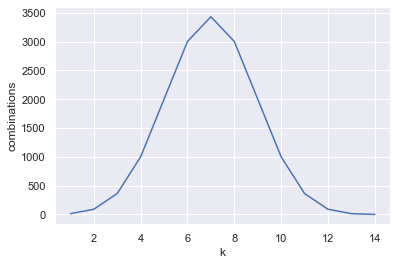

In [19]:
from scipy.special import factorial

n =14
k = np.arange(1, n+1)
y = factorial(n)/(factorial(k) * factorial(n-k))

ax = sns.lineplot(x=k,y=y)
ax.set(xlabel='k', ylabel='combinations')

The plot above shows that there up to ~700,000 possible combinations of the predictors without repetition for some values of k when p = 22

The ISL authors provide comparison of the $R^2$ statistic for all combinations of 19 predictors. When p=19 the max number of combinations for any given subset is reduced by 10x, when p=10 the max combinations is reduced by ~2000x. 

My current machine maxed out its memory trying to compute all models for p=22. I'll try p=14 by picking 14 of the predictors for brevity. 



In [23]:
# Pick arbitrary subset of predictors to save compute/memory
X= hitters.loc[:, 'AtBat':'PutOuts']
y= hitters['Salary']

model_subsets = []
for k in range(1,7):
    subset = get_models(k,X,y)
    model_subsets += [subset]
    print(f'Progress : k = {format(k)}, done,')

# Try it but it works slowly.

Progress : k = 1, done,
Progress : k = 2, done,
Progress : k = 3, done,
Progress : k = 4, done,
Progress : k = 5, done,


In [ ]:
#  RSS BIC and rsquared_adj
rss   = [min_rss(m)[1].ssr for m in model_subsets]
bic = [min_bic(m)[1].bic for m in model_subsets]
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]

k     = np.arange(1, len(rss)+1)

sns.set(rc={'figure.figsize':(16,10)})
_, axes = plt.subplots(1,3)

sns.lineplot(x=k, y=rss,ax = axes[0])
sns.lineplot(x=k, y=adjr2,ax = axes[1])
sns.lineplot(x=k, y=bic,ax = axes[2])
axes[0].set_title('RSS',fontsize=20)
axes[1].set_title('$R_{adj}^2$',fontsize=20)
axes[2].set_title('BIC',fontsize=20)

NameError: name 'model_subsets' is not defined

The stats above seem to confer that a model with around 8 predictors is best. But has each method chosen the same or similar models

In [ ]:
best_subset_6 = list(min_rss(model_subsets[5])[1].params.index)[1:]
print(best_subset_6)

IndexError: list index out of range